In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Cropping2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

In [2]:
batch_size = 1024
# Size of the noise vector
noise_dim = 128
num_classes = 10
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [-1,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

In [3]:
def conv_block(    #Tạo một convolution block
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn: #Dùng bathcnorm hay không
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:  #Có dùng dropout hay không
        x = layers.Dropout(drop_value)(x)
    return x

In [4]:
def get_discriminator_model():
    img_shape = (28,28,1)
    num_classes = 10

    model = Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    # pad input thành (32, 32, 1).
    model.add(ZeroPadding2D((2, 2)))

    model.add(Conv2D(
        filters=64, 
        kernel_size=5,
        strides=2, 
        padding='same', 
        use_bias = True,
    ))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(
        filters=128, 
        kernel_size=5,
        strides=2, 
        padding='same', 
        use_bias = True,
    ))
    
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(
        filters=256, 
        kernel_size=5,
        strides=2, 
        padding='same', 
        use_bias = True,
    ))
    
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(
        filters=512, 
        kernel_size=5,
        strides=2, 
        padding='same', 
        use_bias = True,
    ))
    
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1))

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])
    model_input = keras.layers.Reshape((28,28,1))(model_input)
    # print(model_input.shape)

    validity = model(model_input)

    d_model = Model([img, label], validity, name="discriminator")

    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_2[0][0]                    
______________________________________________________________________________________

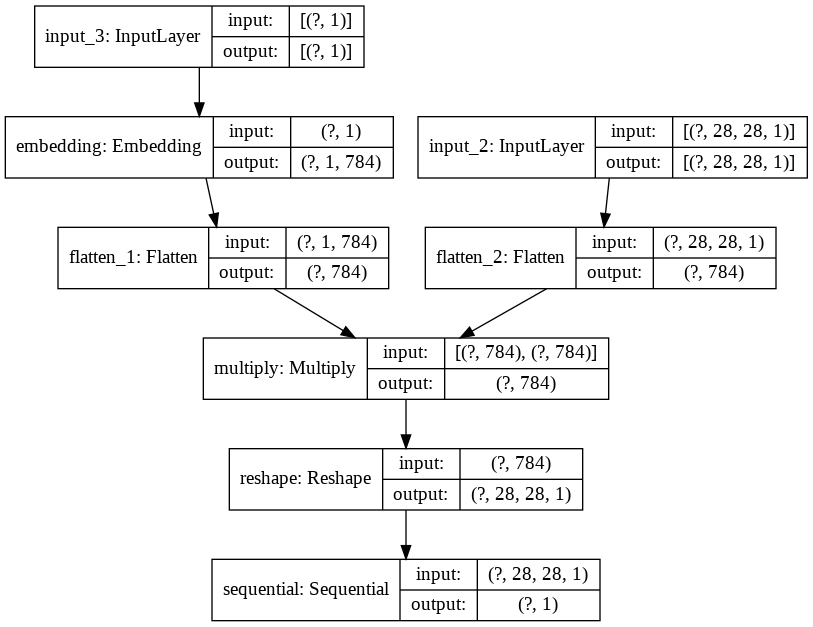

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(d_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

In [7]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    model = Sequential()
    model.add(Dense(4 * 4 * 256, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Reshape((4, 4, 256)))

    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(
        filters=128, 
        kernel_size=3,
        strides=1, 
        padding='same', 
        use_bias = False,
    ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(
        filters=64, 
        kernel_size=3,
        strides=1, 
        padding='same', 
        use_bias = False,
    ))

    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(
        filters=1, 
        kernel_size=3,
        strides=1, 
        padding='same', 
        use_bias = False,
    ))
    model.add(BatchNormalization())
    model.add(Activation("tanh"))


    model.add(Cropping2D((2, 2)))

    label = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Flatten()(layers.Embedding(num_classes, noise_dim)(label))

    model_input = multiply([noise, label_embedding])

    img = model(model_input)
    g_model = Model([noise, label],img, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       1280        input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 128)          0           embedding_1[0][0]                
__________________________________________________________________________________________

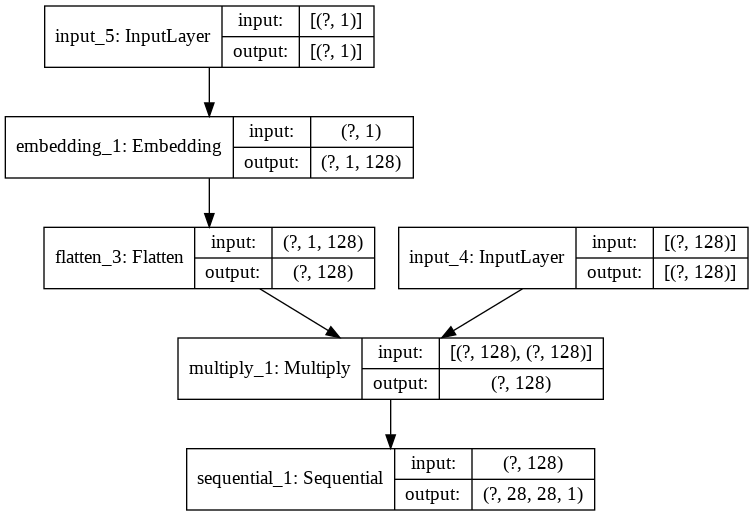

In [8]:
plot_model(g_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
class CWGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(CWGAN, self).__init__()
        self.discriminator = discriminator # model discriminator 
        self.generator = generator         # model generator
        self.latent_dim = latent_dim       # số chiều noise
        self.d_steps = discriminator_extra_steps # số bước lặp thêm cho critic (discriminator)
        self.gp_weight = gp_weight               # alpha trong thuật toán

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(CWGAN, self).compile()
        self.d_optimizer = d_optimizer #optimizer cho critic
        self.g_optimizer = g_optimizer #optimizer cho generator
        self.d_loss_fn = d_loss_fn     #loss function critic
        self.g_loss_fn = g_loss_fn     #loss function gen

    def gradient_penalty(self, batch_size, real_images, fake_images):  #này là hàm lỗi để đánh thêm cho discriminator dựa trên ảnh nội suy
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Tạo một ảnh nội suy
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        # sampled_labels = np.random.randint(0, 10).reshape(-1, 1)

        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. đánh giá một ảnh
            pred = self.discriminator(interpolated, training=True)

        # 2. Tính đạo hàm
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # Với mỗi batch ta tiến hành theo bài báo gốc như sau:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = x_train[idx], y_train[idx]
            real_images = imgs

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, sampled_labels], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images,labels], training=True)
                # Get the logits for the real images
                real_logits = self.discriminator([real_images, labels], training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, sampled_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, sampled_labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [10]:
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        generated_images = self.model.generator([random_latent_vectors, sampled_labels])
        generated_images = (generated_images * 127.5) + 127.5
        print("epoch ",epoch)

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            display(img)

In [11]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img) 
    fake_loss = tf.reduce_mean(fake_img) 
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [12]:
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
cwgan = CWGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3
)

# Compile the WGAN model.
cwgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)

# Start training the model.
cwgan.fit(dataset, epochs=epochs, callbacks=[cbk],verbose=0)

NotImplementedError: ignored